In [1]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from flopy.utils.gridintersect import GridIntersect
import flopy

C:\Users\jlarsen\AppData\Local\Temp\17\ipykernel_23772\2575787959.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Groundwater Modeling and Python Programming

In this exercise, we will use MODPATH to simulate advective transport with the Freyberg flow model. For this exercise, we will use a quadtree version of the Freyberg model.

The location of the contamination patch and the nodes that the define bounding cells of the patch are calculated below.

In [2]:
# patch upper left and lower right
xmin, xmax = 250. * 1, 250. * 3
ymin, ymax = (40 - 14) * 250., (40 - 11) * 250. 

csx, csy = [xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin]
polygon = [list(zip(csx, csy))]
(xmin, ymax), (xmax, ymin)

((250.0, 7250.0), (750.0, 6500.0))

--------------------------

### Define the workspace and model names.

In [4]:
load_ws = pl.Path('data/quadtree')
ws = pl.Path("temp/ex10a")
name = "project"
name_mp = f"{name}_mp"
exe_name = 'mf6'

## Load the MODFLOW 6 Model

Load a simulation object using `flopy.mf6.MFSimulation().load()`.

In [5]:
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name,
                                    sim_ws=load_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading solution package project...


### Load the groundwater flow model

In [6]:
gwf = sim.get_model(name)
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; units:meters; lenuni:2

### Change the workspace

In [7]:
sim.set_sim_path(ws)

### Write the model files

In [8]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...


Run the simulation.

In [9]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\AppData\Local\flopy\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USG

(True, [])

## Create and Run the MODPATH model


### Lets plot the model grid and the location of the contamination patch.

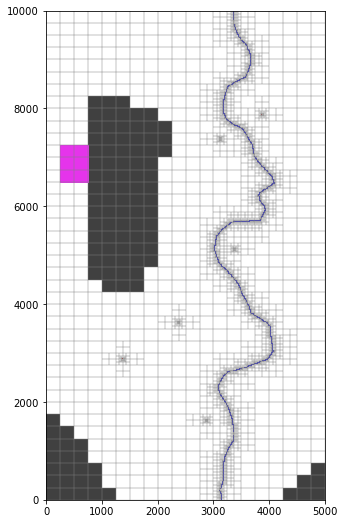

In [10]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(gwf, layer=0, ax=ax)

mm.plot_bc('SFR', color="b", plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_inactive(alpha=0.75)

mm.plot_grid(lw=0.25, color='grey')

ax.fill(csx, csy, color='#e534eb');

Find the node numbers of the contamination patch using the groundwater model grid object and the `GridIntersect` utility. The `GridIntersect` utility has an `intersect` method that can be used to identified cellids from points, lines, and polygons.

In [11]:
gx = GridIntersect(gwf.modelgrid)
results = gx.intersect(polygon, 'Polygon')
nodes = results.cellids
nodes

array([1352, 1353, 1459, 1460, 1581, 1582], dtype=object)

### Create the MODPATH particle data

In [12]:
# create
sd = flopy.modpath.CellDataType()
p = flopy.modpath.NodeParticleData(subdivisiondata=[sd],
                                   nodes=list(nodes))
# create forward particle group
fpth = name_mp + '.sloc'
pg = flopy.modpath.ParticleGroupNodeTemplate(particlegroupname='contaminant',
                                             particledata=p,
                                             filename=fpth)

### Create the MODPATH 7 files

In [13]:
# create modpath files
mp = flopy.modpath.Modpath7(modelname=name_mp, flowmodel=gwf,
                            exe_name='mp7', model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='pathline', 
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  referencetime=0.,
                                  stoptimeoption='extend',
                                  particlegroups=pg)

### Write MODPATH 7 files and run the model

In [14]:
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\AppData\Local\flopy\bin\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jul 05 2023 20:35:59 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
       162 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

## Post-Process the MODFLOW and MODPATH Results


### Load MODFLOW and MODPATH results from the heads and pathline files

Load the MODFLOW heads

In [18]:
hobj = gwf.output.head()

In [19]:
hds = hobj.get_data()

Load the pathline file

In [20]:
ppth =ws / f"{name_mp}.mppth"
p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()

In [22]:
p0

[array([( 291.66666, 7041.6665, 25.157747 ,     0.    , 0, 0),
        ( 292.26523, 7053.434 , 24.259151 ,  1066.6232, 0, 0),
        ( 296.87158, 7187.315 , 18.867577 ,  9176.828 , 1, 0),
        ( 298.29572, 7250.    , 17.83786  , 11656.656 , 2, 0),
        ( 327.38013, 7500.    , 17.041315 , 17482.574 , 2, 0),
        ( 351.95312, 7750.    , 14.886883 , 21403.549 , 2, 0),
        ( 384.25983, 8000.    , 14.738331 , 24241.266 , 2, 0),
        ( 437.98865, 8250.    , 15.478686 , 26416.283 , 2, 0),
        ( 500.     , 8325.292 , 14.165776 , 27109.031 , 2, 0),
        ( 692.9299 , 8500.    , 15.878951 , 28298.334 , 2, 0),
        ( 750.     , 8540.724 , 17.176243 , 28605.803 , 2, 0),
        (1000.     , 8630.868 , 14.297673 , 30072.422 , 2, 0),
        (1250.     , 8669.552 , 14.05823  , 31359.709 , 2, 0),
        (1500.     , 8683.525 , 15.129906 , 32383.266 , 2, 0),
        (1750.     , 8648.858 , 15.427488 , 33216.24  , 2, 0),
        (2000.     , 8599.475 , 13.062349 , 34121.06  ,

### Plot the heads and pathlines

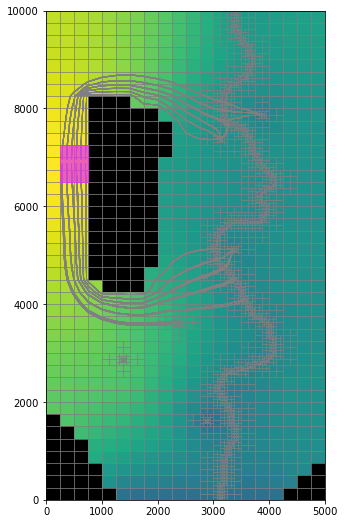

In [31]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
mm.plot_array(hds, masked_values=[1e30])

mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_pathline(p0, layer='all', color='blue', edgecolor="None", lw=0.75)
mm.plot_grid(lw=0.5, color="0.5")

ax = plt.gca()
ax.fill(csx, csy, color='#e534eb', zorder=100, alpha=.75);

### Export the pathlines to a shapefile

In [33]:
spth = pl.Path(ws / 'pathline.shp')
p.write_shapefile(p0, mg=gwf.modelgrid, one_per_particle=False, shpname=spth)

{'names': ['x', 'y', 'z', 'time', 'k', 'particleid'], 'formats': ['<f4', '<f4', '<f4', '<f4', '<i4', '<i4'], 'offsets': [20, 24, 28, 16, 32, 0], 'itemsize': 60}
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


### Load the shapefile into geopandas

In [34]:
rshp = gpd.read_file(spth)

### Show the dataframe

In [35]:
rshp

,x,y,z,time,k,particleid,geometry
0,292.265228,7053.434082,24.259151,1066.623169,1,1,"LINESTRING (291.667 7041.667, 292.265 7053.434)"
1,296.871582,7187.314941,18.867577,9176.828125,2,1,"LINESTRING (292.265 7053.434, 296.872 7187.315)"
2,298.295715,7250.000000,17.837860,11656.656250,3,1,"LINESTRING (296.872 7187.315, 298.296 7250.000)"
3,327.380127,7500.000000,17.041315,17482.574219,3,1,"LINESTRING (298.296 7250.000, 327.380 7500.000)"
4,351.953125,7750.000000,14.886883,21403.548828,3,1,"LINESTRING (327.380 7500.000, 351.953 7750.000)"
...,...,...,...,...,...,...,...
7326,3312.500000,5125.320312,1.554207,49924.312500,3,162,"LINESTRING (3304.377 5125.000, 3312.500 5125.320)"
7327,3328.125000,5128.071289,1.580646,49943.050781,3,162,"LINESTRING (3312.500 5125.320, 3328.125 5128.071)"
7328,3343.750000,5128.837891,1.579881,49954.789062,3,162,"LINESTRING (3328.125 5128.071, 3343.750 5128.838)"
7329,3359.375000,5131.090332,1.578388,49959.777344,3,162,"LINESTRING (3343.750 5128.838, 3359.375 5131.090)"


### Plot the geopandas dataframe on the modelgrid

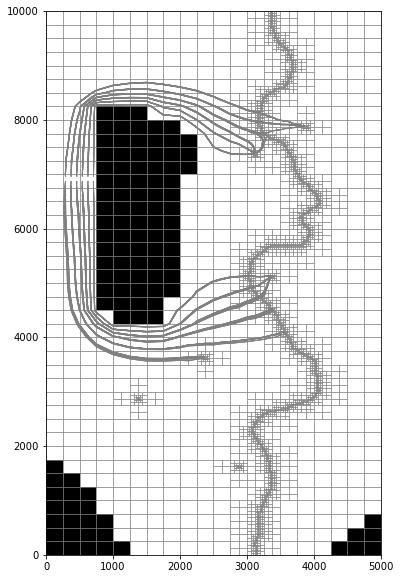

In [36]:
fig, ax = plt.subplots(figsize=(6, 10))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_grid(lw=0.5)
pmv.plot_shapes(rshp.geometry.to_list(), edgecolor="grey") #, edgecolor="b")
pmv.plot_ibound();